In [1]:
import pandas as pd
import numpy as np
import qiime2 as q2
import biom
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, average_precision_score

In [2]:
ft = q2.Artifact.load('../Updated_Data/final_tables/full_table.qza').view(pd.DataFrame)
metadata = pd.read_csv('../Updated_Data/final_tables/metadata_full.tsv', sep='\t', index_col=0)
unmedicated = metadata.loc[metadata['medication_group'] == 'Unmedicated']
medications = metadata.loc[~(metadata['DX_HC']) & (metadata['medication_group']!='Other_Medication') ]  

In [3]:
metadata['N05_Other'] = np.where((metadata['N05A_Antipsychotics']) | (metadata['N05C_Hypnotics_and_Sedatives']), 
                                 True, False)
metadata['N06_Other'] = np.where((metadata['N06B_Psychostimulants_for_ADHD_and_Nootropics']) | 
                                 (metadata['N06D_AntiDementia_drugs']), True, False)

In [4]:
groups_dict = {
    'ANX': metadata.loc[metadata['DX_ANX']], 
    'MDD': metadata.loc[metadata['DX_MDD']],
    'HC': metadata.loc[metadata['DX_HC']]
}

In [5]:
cols_dict = {
    'Number': [np.nan, 'number', np.nan],
    '% with Both': [np.nan, np.nan, np.nan], 
    'Age': ['Age', 'mean', np.nan], 
    'BMI': ['InBody_BMI', 'mean', np.nan], 
    'Sex (% Female)': ['Gender', 'percent', 'Female'], 
    'N05B-Anxiolytics': ['N05B_Anxiolytics', 'percent', True], 
    'N06A-Antidepressants': ['N06A_Antidepressants', 'percent', True],
    'Other N05': ['N05_Other', 'percent', True], 
    'Other N06': ['N06_Other', 'percent', True], 
}

In [7]:
out_df = pd.DataFrame(columns=groups_dict.keys(), index=cols_dict.keys())
for g in groups_dict:
    df = groups_dict[g]
    for c in cols_dict: 
        if c == '% with Both':
            if g != 'HC':
                sub_df = df.loc[(df['DX_ANX']) & (df['DX_MDD'])]
                out_df.loc[c][g] = (np.round(sub_df.shape[0] / df.shape[0]*100, 2))
                
        else: 
            if cols_dict[c][1] == 'percent': 
                sub_df = df.loc[df[cols_dict[c][0]] == cols_dict[c][2]]
                out_df.loc[c][g] = (np.round(sub_df.shape[0] / df.shape[0]*100, 2))
            elif cols_dict[c][1] == 'mean': 
                x_bar = np.round(df[cols_dict[c][0]].mean(), 2)
                std = np.round(df[cols_dict[c][0]].std(), 2)
                out_df.loc[c][g] = str(x_bar) + ' ± ' + str(std)
            elif cols_dict[c][1] == 'number': 
                out_df.loc[c][g] = df.shape[0]
out_df.to_csv('../Updated_Results/Figures/Table1.tsv', sep='\t')

In [8]:
data_dict = {
    'HC vs ANX': ft.loc[metadata.loc[(metadata['DX_HC']) | (metadata['DX_ANX'])].index], 
    'HC vs MDD': ft.loc[metadata.loc[(metadata['DX_HC']) | (metadata['DX_MDD'])].index], 
    'HC vs MDD&ANX': ft.loc[metadata.loc[(metadata['DX_HC']) | (metadata['diagnosis_group'] == 'ANX&MDD')].index], 
    'Unmedicated HC vs ANX': ft.loc[unmedicated.loc[(unmedicated['DX_HC']) | (unmedicated['DX_ANX'])].index],
    'Unmedicated HC vs MDD': ft.loc[unmedicated.loc[(unmedicated['DX_HC']) | (unmedicated['DX_MDD'])].index], 
    'Unmedicated HC vs MDD&ANX': ft.loc[unmedicated.loc[(unmedicated['DX_HC']) | 
                                                        (unmedicated['diagnosis_group'] == 'ANX&MDD')].index], 
    'Unmedicated vs Anxiolytics': ft.loc[medications.loc[(medications['N05B_Anxiolytics']) | 
                                                        (~medications['N06A_Antidepressants'])].index], 
    'Unmedicated vs Antidepressants': ft.loc[medications.loc[(medications['N06A_Antidepressants']) | 
                                                             (~medications['N05B_Anxiolytics'])].index], 
    'Unmedicated vs Anxiolytics&Antidepressants': ft.loc[medications.loc[((medications['N05B_Anxiolytics']) & 
                                                                          (medications['N06A_Antidepressants'])) | 
                                                                         (medications['medication_group'] == 'Unmedicated')].index], 
}

In [25]:
fold_names = {
    'Unmedicated vs Anxiolytics': 14062*5,
    'Unmedicated vs Anxiolytics BIRDMAn':165*5, 
    
    'Unmedicated vs Anxiolytics Only BIRDMAn': 165*5, 
    
    'Unmedicated vs Antidepressants': 14062*5,
    
    'Unmedicated vs Antidepressants BIRDMAn': 175*5,
    
    'Unmedicated vs Antidepressants Only BIRDMAn': 175*5, 
    
    'Unmedicated vs Anxiolytics&Antidepressants': 14062*5, 
    
    'Unmedicated vs Anxiolytics&Antidepressants BIRDMAn':35*5
}

In [26]:
fi = pd.read_csv('../Updated_Data/final_tables/fidf.csv', index_col=0)
medications_fi = pd.read_csv('../Updated_Data/final_tables/medfidf.csv', index_col=0)
updated = []
start_value = 0 
for f in fold_names: 
    end_value = start_value + fold_names[f]
    sub_df = medications_fi[start_value:end_value]
    sub_df['fold'] = f 
    updated.append(sub_df)
    start_value = end_value
updated.append(fi)
all_fi = pd.concat(updated)
#all_fi['fold'].value_counts()

/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/ipykernel_5038/525906925.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['fold'] = f


In [27]:
anxiety_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/anxiety_enriched.csv', index_col=0).index
anx_hc_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/anx_hc_enriched.csv', index_col=0).index
depression_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/depression_enriched.csv', index_col=0).index
mdd_hc_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/mdd_hc_enriched.csv', index_col=0).index

anxiolytics_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/anxiolytics_enriched.csv', index_col=0).index
no_med_anx_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/no_med_anx.csv', index_col=0).index
antidepressants_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/antidepressants_enriched.csv', index_col=0).index
no_med_mdd_taxa = pd.read_csv('../Updated_Data/agp_comp/birdman_sig_plots/no_med_mdd.csv', index_col=0).index


anx_filt = anxiety_taxa.union(anx_hc_taxa) 
mdd_filt = depression_taxa.union(mdd_hc_taxa) 
common_filt = (anxiety_taxa.intersection(depression_taxa)).union(anx_hc_taxa.intersection(mdd_hc_taxa))

anxiolytics_filt = anxiolytics_taxa.union(no_med_anx_taxa) 
antidepressants_filt = antidepressants_taxa.union(no_med_mdd_taxa)
both_filt = (anxiolytics_filt.intersection(antidepressants_taxa)).union(no_med_anx_taxa.intersection(no_med_mdd_taxa))

In [28]:
full_df_list = []
data_dict_birdman = {
    'ANX' : anx_filt, 
    'MDD': mdd_filt, 
    'MDD&ANX': common_filt, 
    'Anxiolytics': anxiolytics_filt, 
    'Antidepressants': antidepressants_filt, 
    'Anxiolytics&Antidepressants': both_filt
}
for i in data_dict_birdman: 
    df = pd.DataFrame(data={'taxa': data_dict_birdman[i], 'subset':i})
    full_df_list.append(df)
birdman_reference_df = pd.concat(full_df_list)

In [16]:
birdman_reference_df.to_csv('../Updated_Data/final_tables/birdman_reference_data.tsv', sep='\t')

In [29]:
def do_ridge(df, md, column_name, random_state= 2, alpha=0.01, l1_ratio=None):
    X = df
    y = md.loc[X.index].get(column_name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    sel_ = SelectFromModel(Ridge(alpha=alpha, random_state=random_state))
    sel_.fit(X, y)
    return X[X.columns[sel_.get_support()]]

In [30]:
def prev_filter(df, min_prev, min_rel_abun = 0):
    row_sum = df.sum(axis = 1)
    df_new = df.div(row_sum, axis = 0)
    df_new[df_new > min_rel_abun] = 1
    col_sum = df_new.sum(axis = 0)
    min_col_sum = min_prev * df.shape[0]
    cols_to_keep = col_sum[col_sum >= min_col_sum].index
    return df[cols_to_keep]

In [38]:
def rf(df, md, n_splits, test_variable, true_value, random_state = 6, use_fi = False):
    if use_fi== True:
        forest = RandomForestClassifier(random_state=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
        feature_names = [X.columns[i] for i in range(X.shape[1])]
        forest = RandomForestClassifier(random_state=0)
        forest.fit(X_train, y_train)
        result = permutation_importance(
                forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        forest_importances = forest_importances.sort_values(ascending=False)
        filist = forest_importances.index.tolist()
        filist
        subsettedX = X[filist]
        subsettedX
    else:
        subsettedX = df
    i_to_id = {i:subsettedX.index[i] for i in range(len(subsettedX.index))}
    y = md.loc[subsettedX.index].get(test_variable)
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    auclist = []
    aprlist = []
    for i, (train_index, test_index) in enumerate(kf.split(subsettedX)):
        train_ids = [i_to_id[j] for j in train_index]
        test_ids = [i_to_id[k] for k in test_index]
        X_train = subsettedX.loc[train_ids]
        y_train = y.loc[train_ids]
    
        X_test = subsettedX.loc[test_ids]
        y_test = y.loc[test_ids]
        rf = RandomForestClassifier(random_state = random_state)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_test)[:, 1]
        fpr, tpr, _, = roc_curve(y_test, y_pred, pos_label=true_value)
        auc = round(roc_auc_score(y_test, y_pred), 4)
        apr = round(average_precision_score(y_test, y_pred, pos_label=true_value), 4)
        auclist.append(auc)
        aprlist.append(apr)
    return pd.DataFrame(data={'auc': auclist, 'apr': aprlist, 'fold': range(n_splits)})

In [51]:
result_dfs = []
random_integers = random.sample(range(1, 101), 10)
for i in range(10): 
    print(i)
    for k in data_dict: 
        if 'HC' in k: 
            test_variable = 'GroupAssignment'
            true_value = 'Mood/Anxiety'
        else: 
            test_variable = 'medication_group'
            true_value = 'Antidepressant/Antianxiety'


        # run helper on full thing 
        unfilt_result = rf(data_dict[k], metadata, 5, test_variable, true_value, random_state=random_integers[i]) 
        unfilt_result['feature_selection'] = 'unfiltered'

        # call prevalence filter 
        prev_filtered = prev_filter(data_dict[k], 0.05, min_rel_abun = 0)
        prev_filtered_result = rf(prev_filtered, metadata, 5, test_variable, true_value, 
                                  random_state=random_integers[i]) 
        prev_filtered_result['feature_selection'] = 'prevalence_filter'

        # call ridge 
        md_copy = metadata.copy()
        md_copy[test_variable] = np.where(md_copy[test_variable] == true_value, 1, 0)
        ridge_filtered = do_ridge(data_dict[k], md_copy, test_variable)
        ridge_filtered_result = rf(ridge_filtered, metadata, 5, test_variable, true_value, 
                                   random_state=random_integers[i])
        ridge_filtered_result['feature_selection'] = 'ridge_filter'

        # FI 
        fi_filter_cols = all_fi.loc[(all_fi['fold'] == k) & (all_fi['importances'] > 0)].index.unique()
        fi_filtered = data_dict[k][fi_filter_cols]
        fi_filtered_result = rf(fi_filtered, metadata, 5, test_variable, true_value,
                                random_state=random_integers[i]) 
        fi_filtered_result['feature_selection'] = 'feature_importance'

        # birdman 
        key_name = k.split(' ')[-1]
        birdman_filter_cols = birdman_reference_df.loc[birdman_reference_df['subset'] == key_name].taxa.values 
        birdman_filtered = data_dict[k][birdman_filter_cols]
        birdman_filtered_results = rf(birdman_filtered, metadata, 5, test_variable, true_value, 
                                      random_state=random_integers[i])
        birdman_filtered_results['feature_selection'] = 'birdman'

        concat_df = pd.concat([unfilt_result, prev_filtered_result, ridge_filtered_result, fi_filtered_result, 
                               birdman_filtered_results])
        concat_df['subset'] = k
        concat_df['iteration'] = i
        result_dfs.append(concat_df)
final_results_auc = pd.concat(result_dfs)

0
1
2
3
4
5
6
7
8
9


In [2]:
#final_results_auc.to_csv('../Updated_Results/auc_results_bygroup.tsv', sep='\t')
final_results_auc = pd.read_csv('../Updated_Results/auc_results_bygroup.tsv', sep='\t')
final_results_auc['feature_selection'].replace({'unfiltered': 'Unfiltered', 
                                                'prevalence_filter': '5% Prevalence Filter', 
                                                'ridge_filter': 'Ridge Filter', 
                                                'feature_importance': 'Feature Importance', 
                                                'birdman': 'BIRDMAn'}, inplace=True)

In [3]:
all_samples = final_results_auc.loc[final_results_auc['subset'].isin(['HC vs ANX', 'HC vs MDD', 'HC vs MDD&ANX'])]
unmedicated = final_results_auc.loc[final_results_auc['subset'].str.startswith('Unmedicated HC')]
medications = final_results_auc.loc[final_results_auc['subset'].str.startswith('Unmedicated vs')]

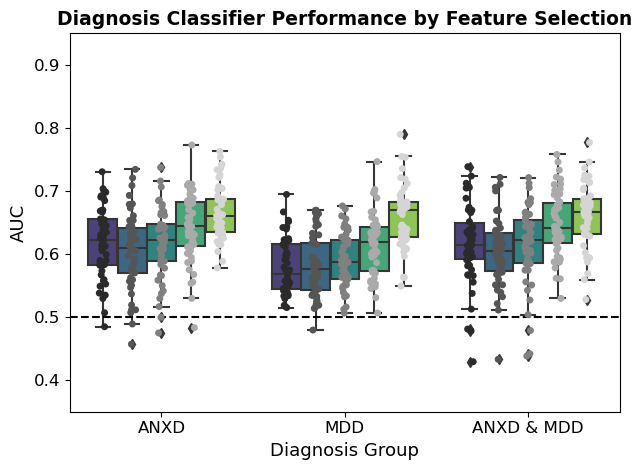

In [5]:
ax = plt.gca()
sns.boxplot(data=all_samples, x='subset', y='auc', hue='feature_selection', ax=ax, palette='viridis')
sns.stripplot(data=all_samples, x='subset', y='auc', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#handles, labels = ax.get_legend_handles_labels()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type')
plt.legend([],[], frameon=False)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('AUC', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xticklabels(['ANXD', 'MDD', 'ANXD & MDD'])
plt.title('Diagnosis Classifier Performance by Feature Selection', fontdict={'weight': 'bold', 
                                                                             'size': 13.5})
ax.hlines(y=0.5, xmin=-0.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.35, 0.95)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig5a.png', transparent=True)

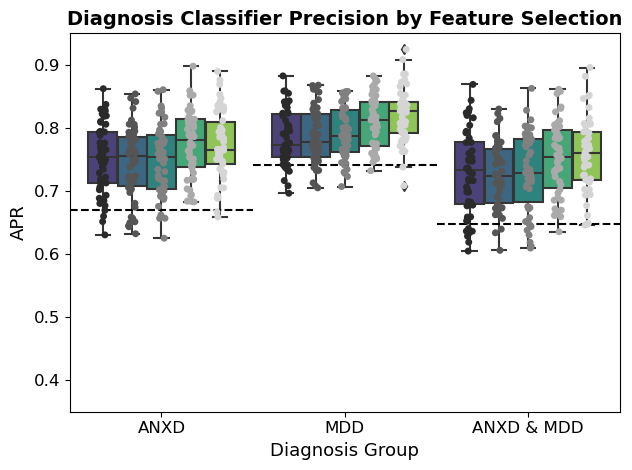

In [13]:
ax = plt.gca()
sns.boxplot(data=all_samples, x='subset', y='apr', hue='feature_selection', ax=ax, palette='viridis')
sns.stripplot(data=all_samples, x='subset', y='apr', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type')
plt.legend([],[], frameon=False)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('APR', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xticklabels(['ANXD', 'MDD', 'ANXD & MDD'])
plt.title('Diagnosis Classifier Precision by Feature Selection', fontdict={'weight': 'bold', 
                                                                           'size': 14})
ax.hlines(y=(301+31)/(301+31+164), xmin=-0.5, xmax=0.5, color='k', linestyle='--')
ax.hlines(y=(301+170)/(301+170+164), xmin=0.5, xmax=1.5, color='k', linestyle='--')
ax.hlines(y=301/(301+164), xmin=1.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.35, 0.95)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs4a.png', transparent=True)

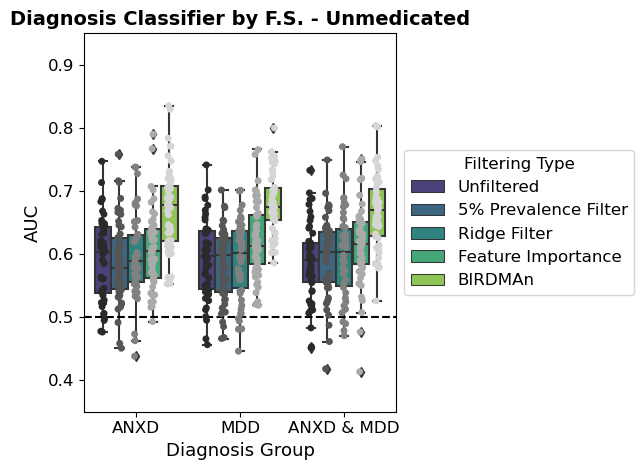

In [17]:
ax = plt.gca()
sns.boxplot(data=unmedicated, x='subset', y='auc', hue='feature_selection', ax=ax, palette='viridis')
sns.stripplot(data=unmedicated, x='subset', y='auc', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type', 
           fontsize=12, title_fontsize=12)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('AUC', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Diagnosis Classifier by F.S. - Unmedicated', fontdict={'weight': 'bold', 'size':14})
ax.set_xticklabels(['ANXD', 'MDD', 'ANXD & MDD'])
ax.hlines(y=0.5, xmin=-0.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.35, 0.95)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig5b.pdf')

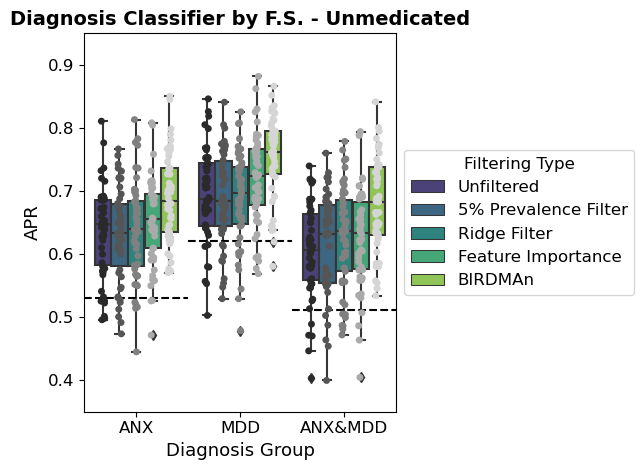

In [18]:
ax = plt.gca()
sns.boxplot(data=unmedicated, x='subset', y='apr', hue='feature_selection', ax=ax, palette='viridis')
sns.stripplot(data=unmedicated, x='subset', y='apr', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type', 
           fontsize=12, title_fontsize=12)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('APR', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Diagnosis Classifier by F.S. - Unmedicated', fontdict={'weight': 'bold', 'size': 14})
ax.set_xticklabels(['ANX', 'MDD', 'ANX&MDD'])
ax.hlines(y=(159+13)/(159+13+152), xmin=-0.5, xmax=0.5, color='k', linestyle='--')
ax.hlines(y=(159+89)/(159+89+152), xmin=0.5, xmax=1.5, color='k', linestyle='--')
ax.hlines(y=159/(159+152), xmin=1.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.35, 0.95)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs4b.pdf')

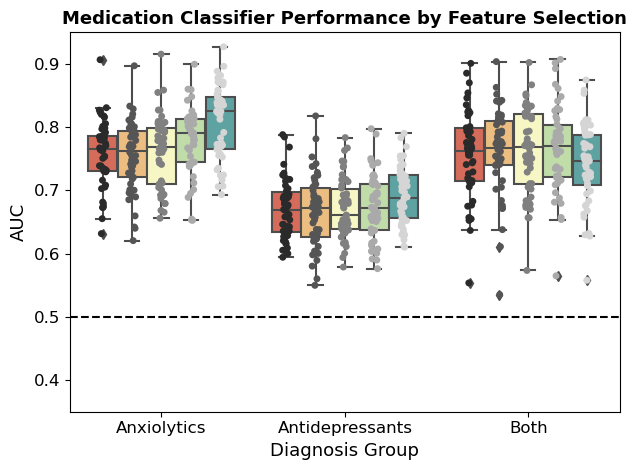

In [6]:
ax = plt.gca()
sns.boxplot(data=medications, x='subset', y='auc', hue='feature_selection', ax=ax, palette='Spectral')
sns.stripplot(data=medications, x='subset', y='auc', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#handles, labels = ax.get_legend_handles_labels()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type')
plt.legend([],[], frameon=False)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('AUC', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Medication Classifier Performance by Feature Selection', fontdict={'weight': 'bold', 
                                                                              'size': 13})
ax.set_xticklabels(['Anxiolytics', 'Antidepressants', 'Both'])
ax.hlines(y=0.5, xmin=-0.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.35, 0.95)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig5c.png', transparent=True)

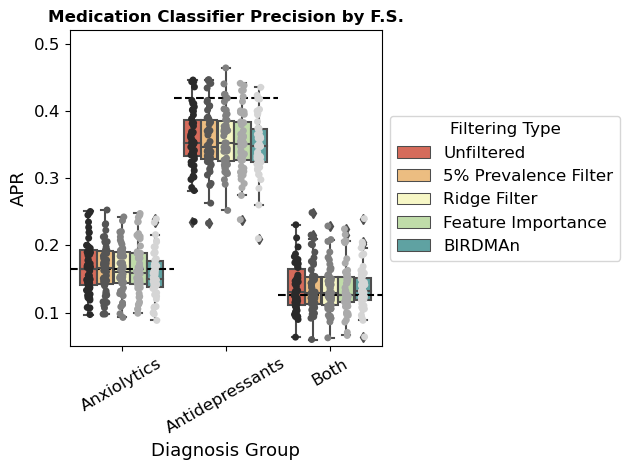

In [4]:
ax = plt.gca()
sns.boxplot(data=medications, x='subset', y='apr', hue='feature_selection', ax=ax, palette='Spectral')
sns.stripplot(data=medications, x='subset', y='apr', hue='feature_selection', dodge=True, ax=ax, 
              palette='gray')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles[:5], title='Filtering Type', 
           fontsize=12, title_fontsize=12)
plt.xlabel('Diagnosis Group', fontsize=13)
plt.ylabel('APR', fontsize=13)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.title('Medication Classifier Precision by F.S.', fontdict={'weight': 'bold'})
ax.set_xticklabels(['Anxiolytics', 'Antidepressants', 'Both'])
ax.hlines(y=(79)/(79+261+141), xmin=-0.5, xmax=0.5, color='k', linestyle='--')
ax.hlines(y=(202)/(202+261+18), xmin=0.5, xmax=1.5, color='k', linestyle='--')
ax.hlines(y=(61)/(202+261+18), xmin=1.5, xmax=2.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.05, 0.52)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs4c.png', transparent=True)